# 呼吸相検出モデル構築　プログラム

# Xgboostを用いた呼吸相分類：間質性肺炎患者のみ

  
本ソースコードでは,聴診器試作機により取得した健常者または間質性肺炎患者の肺音データの中から呼吸相を識別する機械学習モデルを構築する.

データの形式の違いにより読み込みができずに終了したため次回に実行結果を提示する.  
肺音データはmel-スペクトログラムに変換した後, 一定幅のセグメントに分割する.セグメント画像を患者ごとに保存する.  
また,各セグメントに吸気相および呼気相が含まれているかどうかを示すラベル情報とセグメント画像へのパスを示したCSVファイルを事前に作成し,本ソースコードで利用する.  
呼吸相情報は医師の教師データを使用した.


# 11月1日の作業内容記載

## ライブラリのインポート

In [1]:
import pandas as pd
import numpy as np
from PIL import Image
import sys
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import xgboost as xgb
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
warnings.filterwarnings('ignore')
#%matplotlibib inline
sns.set()

### テストファイルの指定

In [2]:
test_file = [3427059]

## 呼吸相画像へのパスとラベル情報が付与されたCSVファイルの読み込み

### TrainとTestで使用するデータを抽出

In [3]:
df_crack = pd.read_csv('Data/mel_spec_breath/csv/breath_mel_spec_crack.csv')
df_crack.head(200)

,index,image_name,patient,state,time,patient_No,breath_phase
0,1,Data/mel_spec_breath/inhall/3427059_Ch0_gray_m...,3427059,1,0,0,1
1,2,Data/mel_spec_breath/inhall/3427059_Ch0_gray_m...,3427059,1,0,0,1
2,3,Data/mel_spec_breath/inhall/3427059_Ch0_gray_m...,3427059,1,0,0,1
3,4,Data/mel_spec_breath/inhall/3427059_Ch0_gray_m...,3427059,1,0,0,1
4,5,Data/mel_spec_breath/inhall/3427059_Ch0_gray_m...,3427059,1,0,0,1
...,...,...,...,...,...,...,...
68,69,Data/mel_spec_breath/exhall/9710964_Ch0_gray_m...,9710964,1,0,0,0
69,70,Data/mel_spec_breath/exhall/9710964_Ch0_gray_m...,9710964,1,0,0,0
70,71,Data/mel_spec_breath/exhall/9710964_Ch0_gray_m...,9710964,1,0,0,0
71,72,Data/mel_spec_breath/exhall/9710964_Ch0_gray_m...,9710964,1,0,0,0


### Trainで使用するデータを抽出

In [4]:
df_train = df_crack[(df_crack["patient"]!=test_file[0])]# & (df_crack["patient"]!=test_file[1])]
train_num = len(df_train)
df_train.reset_index(drop=True, inplace=True)
print(train_num)
df_train

63


,index,image_name,patient,state,time,patient_No,breath_phase
0,6,Data/mel_spec_breath/inhall/4495349_Ch0_gray_m...,4495349,1,0,0,1
1,7,Data/mel_spec_breath/inhall/4495349_Ch0_gray_m...,4495349,1,0,0,1
2,8,Data/mel_spec_breath/inhall/4495349_Ch0_gray_m...,4495349,1,0,0,1
3,9,Data/mel_spec_breath/inhall/4495349_Ch0_gray_m...,4495349,1,0,0,1
4,10,Data/mel_spec_breath/inhall/4495349_Ch0_gray_m...,4495349,1,0,0,1
...,...,...,...,...,...,...,...
58,69,Data/mel_spec_breath/exhall/9710964_Ch0_gray_m...,9710964,1,0,0,0
59,70,Data/mel_spec_breath/exhall/9710964_Ch0_gray_m...,9710964,1,0,0,0
60,71,Data/mel_spec_breath/exhall/9710964_Ch0_gray_m...,9710964,1,0,0,0
61,72,Data/mel_spec_breath/exhall/9710964_Ch0_gray_m...,9710964,1,0,0,0


### Testで使用するデータを取り除く(今回は使用しない)

In [5]:
df_test = df_crack[(df_crack["patient"]==test_file[0])]# | (df_crack["patient"]==test_file[1])]
test_num = len(df_test)
df_test.reset_index(drop=True, inplace=True)
print(test_num)
df_test

10


,index,image_name,patient,state,time,patient_No,breath_phase
0,1,Data/mel_spec_breath/inhall/3427059_Ch0_gray_m...,3427059,1,0,0,1
1,2,Data/mel_spec_breath/inhall/3427059_Ch0_gray_m...,3427059,1,0,0,1
2,3,Data/mel_spec_breath/inhall/3427059_Ch0_gray_m...,3427059,1,0,0,1
3,4,Data/mel_spec_breath/inhall/3427059_Ch0_gray_m...,3427059,1,0,0,1
4,5,Data/mel_spec_breath/inhall/3427059_Ch0_gray_m...,3427059,1,0,0,1
5,37,Data/mel_spec_breath/exhall/3427059_Ch0_gray_m...,3427059,1,0,0,0
6,38,Data/mel_spec_breath/exhall/3427059_Ch0_gray_m...,3427059,1,0,0,0
7,39,Data/mel_spec_breath/exhall/3427059_Ch0_gray_m...,3427059,1,0,0,0
8,40,Data/mel_spec_breath/exhall/3427059_Ch0_gray_m...,3427059,1,0,0,0
9,41,Data/mel_spec_breath/exhall/3427059_Ch0_gray_m...,3427059,1,0,0,0


### 可視化テスト用データの抽出  
間質性肺炎患者1名   
※モデル評価用のテストデータ

In [6]:
path_test_1 = "../Spectrogram/Prototype/mel_spec/"+str(test_file[0])+"_Ch0_mel_spec.png"
#path_test_2 = "../Spectrogram/Prototype/mel_spec/"+test_file[1]+"_Ch0_mel_spec.png"

test_1 = cv2.imread(path_test_1)
#test_2 = cv2.imread(path_test_2)

test_gray_1 = cv2.cvtColor(test_1, cv2.COLOR_BGR2GRAY)
#test_gray_2 = cv2.cvtColor(test_2, cv2.COLOR_BGR2GRAY)
test_gray_1 = test_gray_1[128:256,:]
#test_gray_2 = test_gray_2[128:256,:]

(128, 1584)


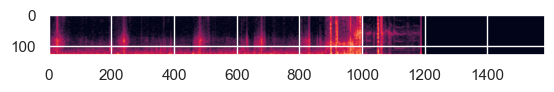

In [7]:
plt.imshow(test_gray_1)
print(test_gray_1.shape)

In [8]:
#plt.imshow(test_gray_2)
#print(test_gray_2.shape)

## 画像を一次元配列のデータとして格納するための訓練用配列とテスト用配列を初期化して用意  

### 訓練データ用配列の初期化

In [9]:
count=0
num_of_data_total=train_num
N_col=128
X = np.zeros((num_of_data_total, N_col))
y = np.zeros((num_of_data_total))
print(X.shape)
print(y.shape)

(63, 128)
(63,)


### テストデータ用配列の初期化

In [10]:
split_num = 186+1#173
num_of_data_total=split_num
N_col=128
X_test_1 = np.zeros((num_of_data_total, N_col))
y_test_1 = np.zeros((num_of_data_total))
#X_test_2 = np.zeros((num_of_data_total, N_col))
#y_test_2 = np.zeros((num_of_data_total))
print(X_test_1.shape)
print(y_test_1.shape)
#print(X_test_2.shape)
#print(y_test_2.shape)

(187, 128)
(187,)


### pathの確認

In [11]:
df_train['image_name']

0     Data/mel_spec_breath/inhall/4495349_Ch0_gray_m...
1     Data/mel_spec_breath/inhall/4495349_Ch0_gray_m...
2     Data/mel_spec_breath/inhall/4495349_Ch0_gray_m...
3     Data/mel_spec_breath/inhall/4495349_Ch0_gray_m...
4     Data/mel_spec_breath/inhall/4495349_Ch0_gray_m...
                            ...                        
58    Data/mel_spec_breath/exhall/9710964_Ch0_gray_m...
59    Data/mel_spec_breath/exhall/9710964_Ch0_gray_m...
60    Data/mel_spec_breath/exhall/9710964_Ch0_gray_m...
61    Data/mel_spec_breath/exhall/9710964_Ch0_gray_m...
62    Data/mel_spec_breath/exhall/9710964_Ch0_gray_m...
Name: image_name, Length: 63, dtype: object

## 画像データの一次元配列化
一次元化の方法により精度が変わるのでデータに適した方法を選択する必要がある.  
検出したい音の特徴が抽出できる方法は音の性質により変化する.

In [12]:
for i in df_train['image_name']:
    im = cv2.imread(i)
    im_gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    #plt.imshow(im_gray)
    #print(i)
    #p=np.array(Image.open(i))
    #im_array = np.var(im_gray,axis=1)#時間軸方向の分散で一次元化
    im_array = np.mean(im_gray,axis=1)#時間軸方向の平均値で一次元化
    #print(im_array.shape)
    #im_array = np.ravel(im_gray)#各時間軸方向の連結で一次元化
    #im_array = np.amax(im_gray,axis=1)#時間軸方向の最大値で一次元化
    #im_array = np.median(im_gray,axis=1)#時間軸方向の中央値で一次元化
    X[count,:] = im_array
    y[count] = df_train['breath_phase'][count]
    count+=1
print(count)

63


### 一次元配列の確認と目的変数の整数変換

In [13]:
print(im_array.shape)
y = y.astype(np.int64)
print(y)

(128,)
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [14]:
(20/1584)*96

1.2121212121212122

In [15]:
(20/1584)*8

0.10101010101010101

In [16]:
count=0
cut_size = 96
hop_range = 8

for i in range(split_num):
    im = test_gray_1[:,i*hop_range:i*hop_range+cut_size]
    #p=np.array(Image.open(i))
    #im_array = np.var(im,axis=1)#時間軸方向の分散で一次元化
    im_array = np.mean(im,axis=1)#時間軸方向の平均値で一次元化
    #print(im_array.shape)
    #im_array = np.ravel(im)#各時間軸方向の連結で一次元化
    #im_array = np.amax(im,axis=1)#時間軸方向の最大値で一次元化
    #im_array = np.median(im_gray,axis=1)#時間軸方向の中央値で一次元化
    X_test_1[count,:] = im_array
    count+=1
print(i)   

'''
count=0
for i in range(split_num):
    im = test_gray_2[:,i*hop_range:i*hop_range+cut_size]
    #p=np.array(Image.open(i))
    #im_array = np.var(im,axis=1)#時間軸方向の分散で一次元化
    im_array = np.mean(im,axis=1)#時間軸方向の平均値で一次元化
    #print(im_array.shape)
    #im_array = np.ravel(im)#各時間軸方向の連結で一次元化
    #im_array = np.amax(im,axis=1)#時間軸方向の最大値で一次元化
    X_test_2[count,:] = im_array
    count+=1
print(i)
'''

186


'\ncount=0\nfor i in range(split_num):\n    im = test_gray_2[:,i*hop_range:i*hop_range+cut_size]\n    #p=np.array(Image.open(i))\n    #im_array = np.var(im,axis=1)#時間軸方向の分散で一次元化\n    im_array = np.mean(im,axis=1)#時間軸方向の平均値で一次元化\n    #print(im_array.shape)\n    #im_array = np.ravel(im)#各時間軸方向の連結で一次元化\n    #im_array = np.amax(im,axis=1)#時間軸方向の最大値で一次元化\n    X_test_2[count,:] = im_array\n    count+=1\nprint(i)\n'

In [17]:
i*hop_range+cut_size

1584

In [18]:
X_test_1

array([[ 19.88541667,  20.34375   ,  23.01041667, ..., 132.5625    ,
        142.22916667, 234.27083333],
       [ 16.67708333,  17.15625   ,  19.61458333, ..., 130.32291667,
        142.76041667, 234.51041667],
       [ 16.59375   ,  17.30208333,  20.28125   , ..., 129.54166667,
        143.05208333, 234.60416667],
       ...,
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ]])

In [19]:
X_test_1.shape

(187, 128)

In [20]:
df_X = pd.DataFrame(X)
df_test_1 = pd.DataFrame(X_test_1)
#df_test_2 = pd.DataFrame(X_test_2)
#df_X

## 各ラベルの比率を表示
非捻発音：0  
捻発音：1

In [21]:
df_train["breath_phase"].value_counts()

0    32
1    31
Name: breath_phase, dtype: int64

## ラベルの比率を揃えるためのアンダーサンプリング

In [22]:
'''
from imblearn.under_sampling import RandomUnderSampler
neg_count_train = df_train["breath_phase"].value_counts()[1]
strategy = {0:neg_count_train, 1:neg_count_train}
rus = RandomUnderSampler(random_state=2, sampling_strategy=strategy)
X_res, y_res = rus.fit_resample(X,y)
print("サンプリング後のデータ数:"+str(len(X_res)))
'''

'\nfrom imblearn.under_sampling import RandomUnderSampler\nneg_count_train = df_train["breath_phase"].value_counts()[1]\nstrategy = {0:neg_count_train, 1:neg_count_train}\nrus = RandomUnderSampler(random_state=2, sampling_strategy=strategy)\nX_res, y_res = rus.fit_resample(X,y)\nprint("サンプリング後のデータ数:"+str(len(X_res)))\n'

## 訓練データと検証データへの分割

In [23]:
X_train, X_eval, y_train, y_eval = train_test_split(df_X, y, test_size=0.20, stratify=y, random_state=2)
#X_train, X_eval, y_train, y_eval = train_test_split(feature[:,0:20], y, test_size=0.3, stratify=y, random_state=3)
#X_train, X_eval, y_train, y_eval = train_test_split(X_res, y_res, test_size=0.2, stratify=y_res, random_state=0)

## XGboostモデルの作成(モデルの超パラメータはここで設定)

In [24]:
fit_params ={'verbose':True,
            'early_stopping_rounds':10,
            'eval_metric':'logloss',
            'eval_set':[(X_eval, y_eval)]
            }
model = XGBClassifier(eta = 0.01,max_depth=3,min_child_weigh=10,booster='gbtree',objective='binary:logistic',use_label_encoder=False,random_state=0)

## 交差検証による簡易な精度確認
※メモリを消費が大きいので注意

In [25]:
'''
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score


cv = StratifiedKFold(n_splits=5,shuffle=True, random_state=0)
scoring = 'accuracy'
scores = cross_val_score(model, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1, fit_params=fit_params)
print(f'scores={scores}')
print(f'average_score={np.mean(scores)}')
'''

"\nfrom sklearn.model_selection import KFold\nfrom sklearn.model_selection import StratifiedKFold\nfrom sklearn.model_selection import cross_val_score\n\n\ncv = StratifiedKFold(n_splits=5,shuffle=True, random_state=0)\nscoring = 'accuracy'\nscores = cross_val_score(model, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1, fit_params=fit_params)\nprint(f'scores={scores}')\nprint(f'average_score={np.mean(scores)}')\n"

## 学習

In [26]:
%%time
eval_set = [(X_eval, y_eval)]
model.fit(X_train, y_train, early_stopping_rounds=100, eval_set=eval_set, verbose=True)#,sample_weight=weight_train

[21:46:50] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "min_child_weigh" } are not used.

[0]	validation_0-logloss:0.68825
[1]	validation_0-logloss:0.68281
[2]	validation_0-logloss:0.67748
[3]	validation_0-logloss:0.67287
[4]	validation_0-logloss:0.66774
[5]	validation_0-logloss:0.66332
[6]	validation_0-logloss:0.65899
[7]	validation_0-logloss:0.65414
[8]	validation_0-logloss:0.64939
[9]	validation_0-logloss:0.64531
[10]	validation_0-logloss:0.64132
[11]	validation_0-logloss:0.63683
[12]	validation_0-logloss:0.63299
[13]	validation_0-logloss:0.62867
[14]	validation_0-logloss:0.62443
[15]	validation_0-logloss:0.62082
[16]	validation_0-logloss:0.61673
[17]	validation_0-logloss:0.61326
[18]	validation_0-logloss:0.60986
[19]	validation_0-logloss:0.60600
[20]	validation_0-logloss:0.60273
[21]	validation_0-logloss:0.59900
[22]	validation_0-logloss:0.59535
[23]	validation_0-logloss:0.59227
[24]	

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.01, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weigh=10, min_child_weight=None,
              missing=nan, monotone_constraints=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, ...)

## 変数重要度の出力
上位100変数  
f1=周波数1Hz

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

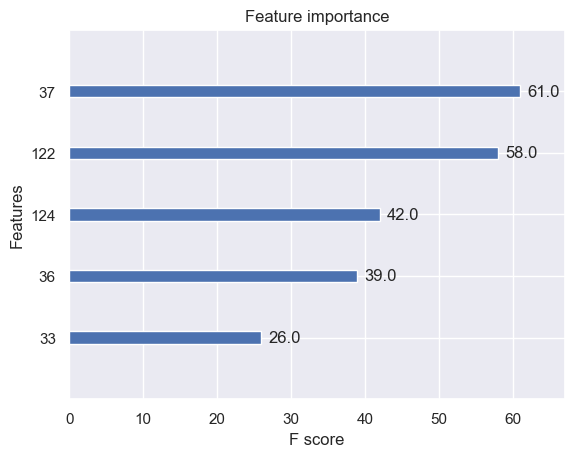

In [27]:
fig, ax = plt.subplots()#figsize=(28, 80)
xgb.plot_importance(model,ax=ax,max_num_features=10)

## 訓練したモデルを用いてテストデータと可視化用テストデータを予測

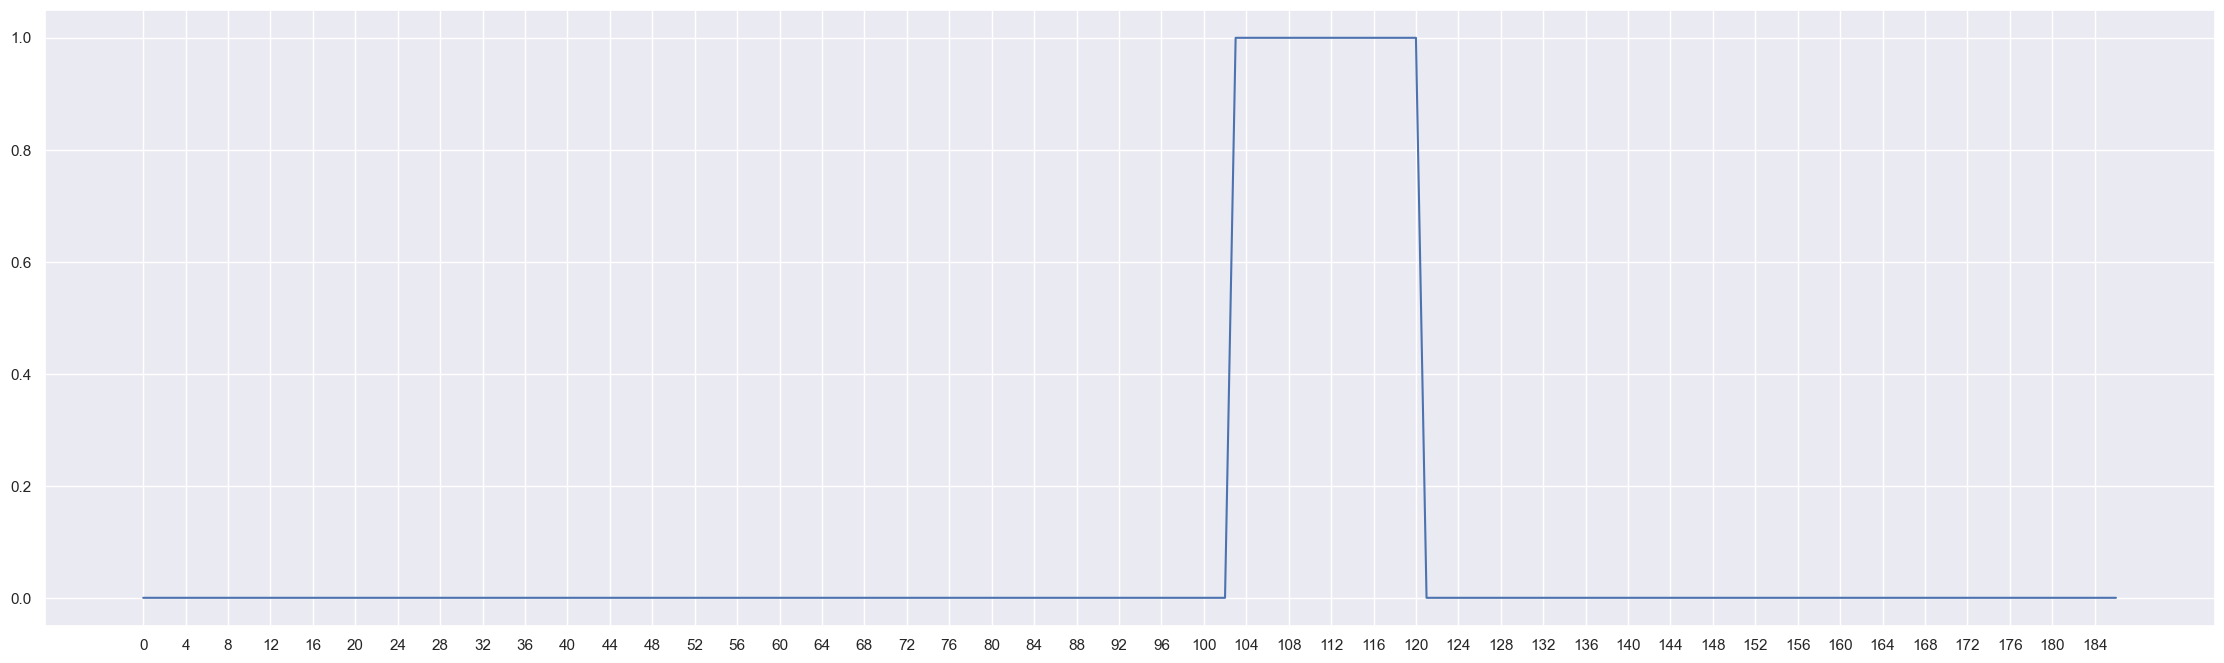

In [28]:
from sklearn import metrics
#y_pred = model.predict_proba(X_test)
#y_pred_max = np.argmax(y_pred, axis=1)
y_pred_1 = model.predict_proba(X_test_1)
y_pred_1 = np.argmax(y_pred_1, axis=1)
#print("Train :", model.score(X_train, y_train))
#print("Test :", model.score(X_t, y_t))
fig, ax = plt.subplots(figsize=(28, 8))
plt.plot(y_pred_1)
ax.set_xticks(np.arange(0, 187, 4))
plt.show()

## 吸気時間算出

In [29]:
inhall_time_1 = []
inhall_index_1 = []

if y_pred_1[0]==1:
    inhall_time_1.append(0)
    inhall_index_1.append(0)
    
for i in range(len(y_pred_1)-1):
    if y_pred_1[i]-y_pred_1[i+1]==1:
        inhall_time_1.append(i*8*(20/1584)+96*(20/1584))
        inhall_index_1.append(i)
    elif y_pred_1[i]-y_pred_1[i+1]==-1:
        inhall_time_1.append(i*8*(20/1584))
        inhall_index_1.append(i)

print(inhall_time_1)
print(inhall_index_1)

[10.303030303030303, 13.333333333333334]
[102, 120]


In [30]:
'''
y_pred_2 = model.predict_proba(X_test_2)
y_pred_2 = np.argmax(y_pred_2, axis=1)
fig, ax = plt.subplots(figsize=(28, 8))
plt.plot(y_pred_2)
#ax.set_xticks(np.arange(0, 172, ))
plt.show()
'''

'\ny_pred_2 = model.predict_proba(X_test_2)\ny_pred_2 = np.argmax(y_pred_2, axis=1)\nfig, ax = plt.subplots(figsize=(28, 8))\nplt.plot(y_pred_2)\n#ax.set_xticks(np.arange(0, 172, ))\nplt.show()\n'

## モデルの精度評価

In [31]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

### テストデータの精度評価指標（適合率,再現率,F1スコア,正解率） 

In [ ]:
'''
c_rep = classification_report(y_t, y_pred_max_t)
print(c_rep)
'''

## 11/1
## 新規間質性肺炎患者の呼吸相識別実施
###  聴診器試作機から得た6件の新しい健常者データによる肺音のみでモデルを作成し精度調査

間質性肺炎患者1件のテストデータを確認したところ、吸気相をほぼ確認できていないことが確認された  
本調査では5件のデータでのみ学習モデルの訓練を実施している  
データ数が極端に少なすぎるため今後はデータ数を増やすデータ拡張や追加実験により、精度がどのように変化するのかを調査する  